In [1]:
spark

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 15, 6, Finished, Available)

In [7]:
## Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 15, 12, Finished, Available)

In [8]:
# Defining Location of Data
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

# Reading in Data
comments_path = "/basketball_comments_sep.parquet"
submissions_path = "/basketball_submissions_sep.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

# Removing Missing Data
missing_values = ["", "[deleted]", "[removed]"]
missing_df = submissions.withColumn("selftext", when(col("selftext").isin(missing_values), None).otherwise(col("selftext")))
missing_df_c = comments.withColumn("body", when(col("body").isin(missing_values), None).otherwise(col("body")))
submissions = missing_df.na.drop(subset=["selftext"])
comments = missing_df_c.na.drop(subset = ["body"])
submissions = submissions.cache()
comments = comments.cache()

# Creating Day, Month, Year Columns
submissions = (
    submissions
    .withColumn("day", dayofmonth(col("created_utc")))
    .withColumn("month", month(col("created_utc")))
    .withColumn("year", year(col("created_utc")))
)
comments = (
    comments
    .withColumn("day", dayofmonth(col("created_utc")))
    .withColumn("month", month(col("created_utc")))
    .withColumn("year", year(col("created_utc")))
)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 15, 13, Finished, Available)

#### Number of Submissions and Comments Per Day in `r/CollegeBasketball`

In [22]:
q = (
    comments
    .filter(col("subreddit") == "CollegeBasketball") # filter to only collegebasketball subreddit
    .groupBy("year", "month", "day") # group by day
    .count() # return count
)
df = q.toPandas() # send to pandas

t = (
    submissions
    .filter(col("subreddit") == "CollegeBasketball") # filter to only collegebasketball subreddit
    .groupBy("year", "month", "day") # group by day
    .count() # return count
)
df_s = t.toPandas() # send to pandas

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values(by='date') 

df_s['date'] = pd.to_datetime(df_s[['year', 'month', 'day']])
df_s = df_s.sort_values(by='date') 

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 15, 27, Finished, Available)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 15, 28, Finished, Available)

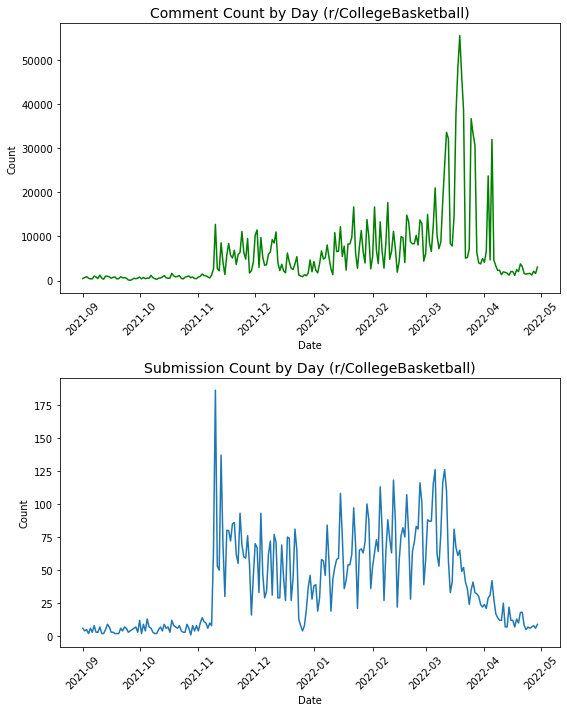

In [23]:
# Plot counts of comments and submissions by day
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
ax1.plot(df['date'], df['count'], linestyle='-', color = "green")
ax2.plot(df_s['date'], df_s['count'], linestyle='-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.set_title('Comment Count by Day (r/CollegeBasketball)', fontsize = 14)
ax1.tick_params(axis='x', rotation=45)


ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
ax2.set_title('Submission Count by Day (r/CollegeBasketball)', fontsize = 14)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Given that the first college basketball game in this season was November 9th, 2021 these counts of comments and submissions per day make sense. We see lower comments and submissions leading up to the season. This is where the two groups deviate. 

Submissions spike right at the beginning of the season (lots of fans critiquing or praising their new look teams perhaps?), then we see a drop off in submissions as the season settles in, followed by a rise up to the tournament in March, with a quick drop off in the middle of March as many teams are eliminated from contention for the title. 

Comments, on the other hand are relatively low at the start of the season, and see a rise up until the NCAA tournament in March/April.

This indicates that commenting is perhaps more common later in the season as competition because more important and the NCAA tournament gets closer. Submissions are more steady perhaps because these are longer posts that mostly year long fans write. 

#### Average Word Count in `Submissions` and `Comments` by Day

In [33]:
# get average word count by day
t = (
    submissions
    .filter(col("subreddit") == "CollegeBasketball") # keep only college basketball subreddit
    .withColumn("word_count", size(split(col("selftext"), "\\s+"))) # get size of selftext column split by spaces (# of words)
    .groupBy("year", "month", "day")  # group by day
    .agg(avg("word_count").alias("avg_words")) # average number of words per day
)
q = (
    comments
    .filter(col("subreddit") == "CollegeBasketball")  # keep only college basketball subreddit
    .withColumn("word_count", size(split(col("body"), "\\s+"))) # get size of selftext column split by spaces (# of words)
    .groupBy("year", "month", "day")  # group by day
    .agg(avg("word_count").alias("avg_words")) # average number of words per day
)
# convert grouped data to pandas
df_s = t.toPandas()
df = q.toPandas()
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values(by='date') 

df_s['date'] = pd.to_datetime(df_s[['year', 'month', 'day']])
df_s = df_s.sort_values(by='date') 

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 15, 38, Finished, Available)

StatementMeta(d3c1b951-094c-48e1-919d-e32bc175397b, 15, 39, Finished, Available)

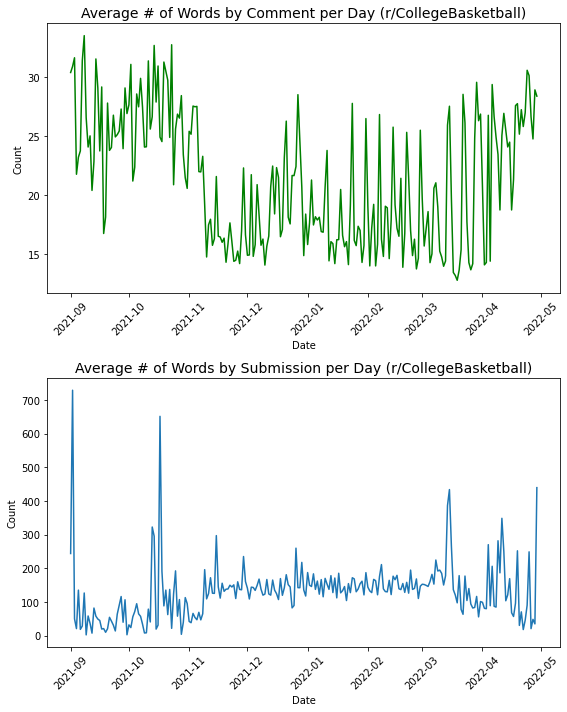

In [34]:
# Plot average word count by day
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
ax1.plot(df['date'], df['avg_words'], linestyle='-', color = "green")
ax2.plot(df_s['date'], df_s['avg_words'], linestyle='-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.set_title('Average # of Words by Comment per Day (r/CollegeBasketball)', fontsize = 14)
ax1.tick_params(axis='x', rotation=45)


ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
ax2.set_title('Average # of Words by Submission per Day (r/CollegeBasketball)', fontsize = 14)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In the comments dataframe we see that the average length each comment is longer before the season starts (November 1st), than during the season (November 1st - April 5th). This is likely because of the lack of posts during the preseason as we saw the in the previous graph. It does say something interesting though that the few people who do comment in the subreddit during the offseason, typically are writing longer comments. 

In the submissions dataframe we see a different trend. The offseason has fewer or the same average words per submission, however we do see some spikes. After digging into these specific days we identified that these spikes with 600+ words per day occured on days with very few posts (<5) and one of those posts was particularly long. For example on September 2nd, 2021 one user detailed their year long simulation of which college basketball teams were the most lucky, and on October 17th, 2021 another user listed each college basketball team where the first letters of the teams names were swapped (Tar Heels = Har Teels). 

The spike in March of 2022 for submissions is the same day as the start of the 2022 NCAA Basketball Tournament. 